In [1]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Part 1: Time Series Prep
## 1: Download SPTL ETF Data

In [2]:
sptl = yf.download('SPTL', start='2023-01-01', end='2023-12-31', interval='1d')

# Fix MultiIndex issue: Drop the second level from columns
if isinstance(sptl.columns, pd.MultiIndex):
    sptl.columns = sptl.columns.droplevel(1)  # Remove second level

# Keep only 'Close' prices and rename
sptl = sptl[['Close']].rename(columns={'Close': 'SPTL_Close'})

# Convert index to Date format
sptl.index = pd.to_datetime(sptl.index).date
sptl = pd.DataFrame(sptl)  # Convert back to DataFrame
sptl.index = pd.to_datetime(sptl.index)  # Convert back to datetime
print(sptl.head())
print("Length of SPTL:", len(sptl))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price       SPTL_Close
2023-01-03   27.326902
2023-01-04   27.669300
2023-01-05   27.780348
2023-01-06   28.261555
2023-01-09   28.400368
Length of SPTL: 250


## 2: Load EFFR Data from Excel

In [2]:
effr = pd.read_excel('EFFR.xlsx')[['Effective Date', 'Rate (%)']]
effr.rename(columns={'Effective Date': 'Date', 'Rate (%)': 'EFFR'}, inplace=True)
effr['Date'] = pd.to_datetime(effr['Date'])
effr.set_index('Date', inplace=True)
effr = effr.sort_index()

# Convert index to Date format
effr.index = effr.index.date
effr = pd.DataFrame(effr)  # Convert back to DataFrame
effr.index = pd.to_datetime(effr.index)  # Convert back to datetime

print(effr.head())
print("Length of EFFR:", len(effr))

            EFFR
2023-01-03  4.33
2023-01-04  4.33
2023-01-05  4.33
2023-01-06  4.33
2023-01-09  4.33
Length of EFFR: 250


## 3: Identify Non-Matching Dates and Fix Them

In [4]:
print("The dates that differ between SPTL and EFFR:")
mismatched_sptl = sptl.index.difference(effr.index)
mismatched_effr = effr.index.difference(sptl.index)
print("Dates in SPTL but not in EFFR:", mismatched_sptl)
print("Dates in EFFR but not in SPTL:", mismatched_effr)

# Drop non-matching dates in SPTL and forward-fill missing values in EFFR
sptl = sptl[~sptl.index.isin(mismatched_sptl)]
effr = effr.reindex(sptl.index, method='ffill')  # Fill missing EFFR values

The dates that differ between SPTL and EFFR:
Dates in SPTL but not in EFFR: DatetimeIndex(['2023-10-09'], dtype='datetime64[ns]', freq=None)
Dates in EFFR but not in SPTL: DatetimeIndex(['2023-04-07'], dtype='datetime64[ns]', freq=None)


## 4: Merge Data

In [5]:
data = sptl.join(effr, how="inner")

# Convert EFFR annual rate to daily risk-free rate
data['Daily_EFFR'] = (data['EFFR'] / 100.0) / 252.0

# Compute Daily Returns and Excess Returns
data['SPTL_Return'] = data['SPTL_Close'].pct_change()
data['Excess_Return'] = data['SPTL_Return'] - data['Daily_EFFR']

# Drop NaN values
data.dropna(inplace=True)

## 5: Plot Data

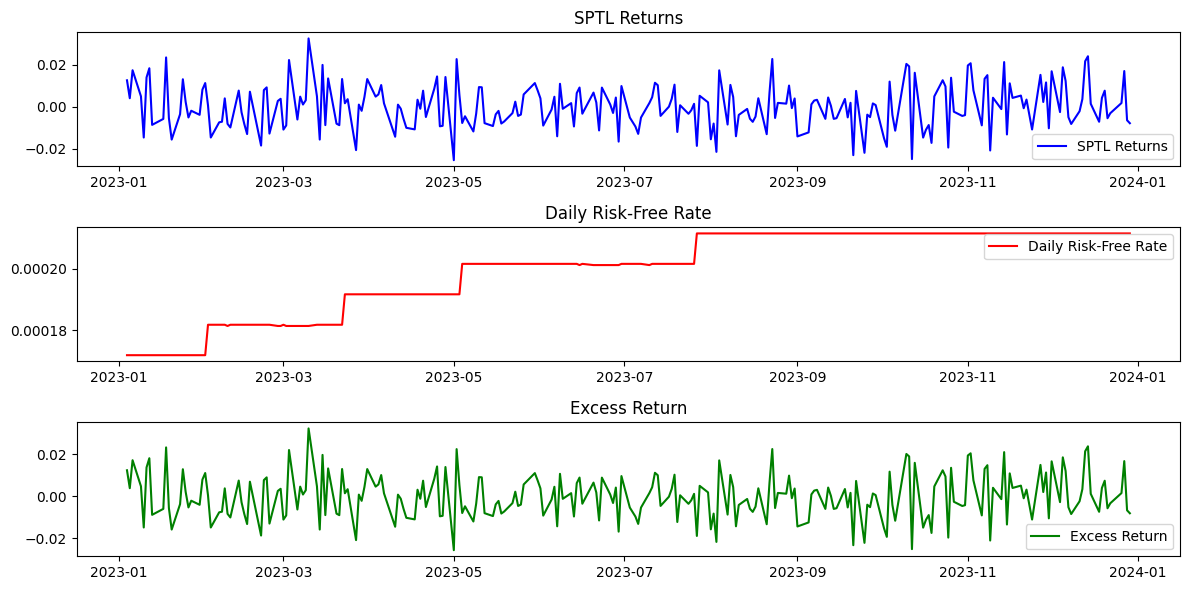

In [13]:
plt.figure(figsize=(12, 6))

# First subplot: SPTL Returns
plt.subplot(3, 1, 1)
plt.plot(data.index, data['SPTL_Return'], label='SPTL Returns', color='blue')
plt.legend()
plt.title('SPTL Returns')

# Second subplot: Daily Risk-Free Rate
plt.subplot(3, 1, 2)
plt.plot(data.index, data['Daily_EFFR'], label='Daily Risk-Free Rate', color='red')
plt.legend()
plt.title('Daily Risk-Free Rate')

# Third subplot: Excess Return
plt.subplot(3, 1, 3)
plt.plot(data.index, data['Excess_Return'], label='Excess Return', color='green')
plt.legend()
plt.title('Excess Return')

plt.tight_layout()
plt.show()


# Part 2: Trading Strategies
## 1. Initial Capital and Leverage

In [7]:
initial_capital = 100000.0
leverage = 10.0

## 2. Define leverage running strategy

In [14]:
def run_leveraged_strategy(data, strategy_name, initial_capital, leverage, strategy_function):
    """
    data: DataFrame with columns:
        - 'SPTL_Close'
        - 'Daily_EFFR'
        - 'SPTL_Return' (daily returns)
    strategy_name: string label
    initial_capital: float
    leverage: float
    strategy_function: function that takes (day_index, V_total, price, risk_free, ...) 
                       and returns a new position (theta_t)
    """
    dates = data.index
    n = len(dates)
    
    # Arrays to store daily results
    V_total = np.zeros(n)
    theta = np.zeros(n)       # dollar value of SPTL
    DeltaV_trading = np.zeros(n)
    DeltaV_cap = np.zeros(n)
    DeltaV_total = np.zeros(n)
    
    # Initialize
    V_total[0] = initial_capital
    # Decide initial theta (the strategy function might define it)
    # Or we can let the strategy function handle day 0 as well
    theta[0] = strategy_function(0, V_total[0], data["SPTL_Close"].iloc[0], data["Daily_EFFR"].iloc[0])
    # Ensure |theta[0]| <= V_total[0] * L
    theta[0] = np.clip(theta[0], -V_total[0]*leverage, V_total[0]*leverage)
    
    for t in range(0, n-1):
        price_t = data['SPTL_Close'].iloc[t]
        price_next = data['SPTL_Close'].iloc[t+1]
        rft = data['Daily_EFFR'].iloc[t]

        if price_t <= 0:
            raise ValueError(f"Invalid price at index {t}: {price_t}")
        ret_t = (price_next - price_t) / price_t

        DeltaV_trading[t+1] = (ret_t - rft) * theta[t]
        margin_t = abs(theta[t]) / leverage
        DeltaV_cap[t+1] = (V_total[t] - margin_t) * rft
        DeltaV_total[t+1] = DeltaV_trading[t+1] + DeltaV_cap[t+1]

        if t % 50 == 0:
            print(f"t={t}, Strategy={strategy_name}, theta={theta[t]}, ret_t={ret_t}, rft={rft}, DeltaV_trading={DeltaV_trading[t+1]}, DeltaV_cap={DeltaV_cap[t+1]}")

        V_total[t+1] = V_total[t] + DeltaV_total[t+1]
        if V_total[t+1] <= 0:
            print(f"Account liquidated at t={t+1}, date={dates[t+1]}")
            V_total[t+1:] = 0
            theta[t+1:] = 0
            DeltaV_trading[t+1:] = 0
            DeltaV_cap[t+1:] = 0
            DeltaV_total[t+1:] = 0
            break

        next_rft = data['Daily_EFFR'].iloc[t+1]
        next_price = data['SPTL_Close'].iloc[t+1]
        theta[t+1] = strategy_function(t+1, V_total[t+1], next_price, next_rft)
        max_allowed = V_total[t+1] * leverage
        theta[t+1] = np.clip(theta[t+1], -max_allowed, max_allowed)

    results = pd.DataFrame({
        "V_total": V_total,
        "theta": theta,
        "DeltaV_trading": DeltaV_trading,
        "DeltaV_cap": DeltaV_cap,
        "DeltaV_total": DeltaV_total
    }, index=dates)
    return results

## 3.  Stategies1： "Buy and Hold"

In [10]:
def buy_and_hold_function(t, V_now, price_now, rf_now):
    """
    Returns a notional position theta_t such that
    |theta_t| <= V_now * leverage on every day.

    Here we choose to always be fully leveraged on the long side,
    i.e., theta_t = V_now * leverage.
    """
    # Fully leveraged long position
    return V_now * leverage


## 4. Stategies2： "Moving Average Crossover"

In [11]:
short_window = 20
long_window = 50
data["MA_short"] = data["SPTL_Close"].rolling(window=short_window, min_periods=1).mean()
data["MA_long"] = data["SPTL_Close"].rolling(window=long_window, min_periods=1).mean()

def ma_crossover_function(t, V_now, price_now, rf_now):
    # If short MA > long MA => signal=1, else signal=-1
    if t < long_window:
        # not enough data, let's stay flat or partial
        return 0.0
    else:
        if data["MA_short"].iloc[t] > data["MA_long"].iloc[t]:
            return V_now * leverage  # fully long
        else:
            return -V_now * leverage # fully short


# Run the two strategies
results_bh = run_leveraged_strategy(data, "Buy & Hold", initial_capital, leverage, buy_and_hold_function)
results_ma = run_leveraged_strategy(data, "MA Crossover", initial_capital, leverage, ma_crossover_function)

## Plot DeltaV_trading, DeltaV_cap, DeltaV_total and their cumulatives for each strategy

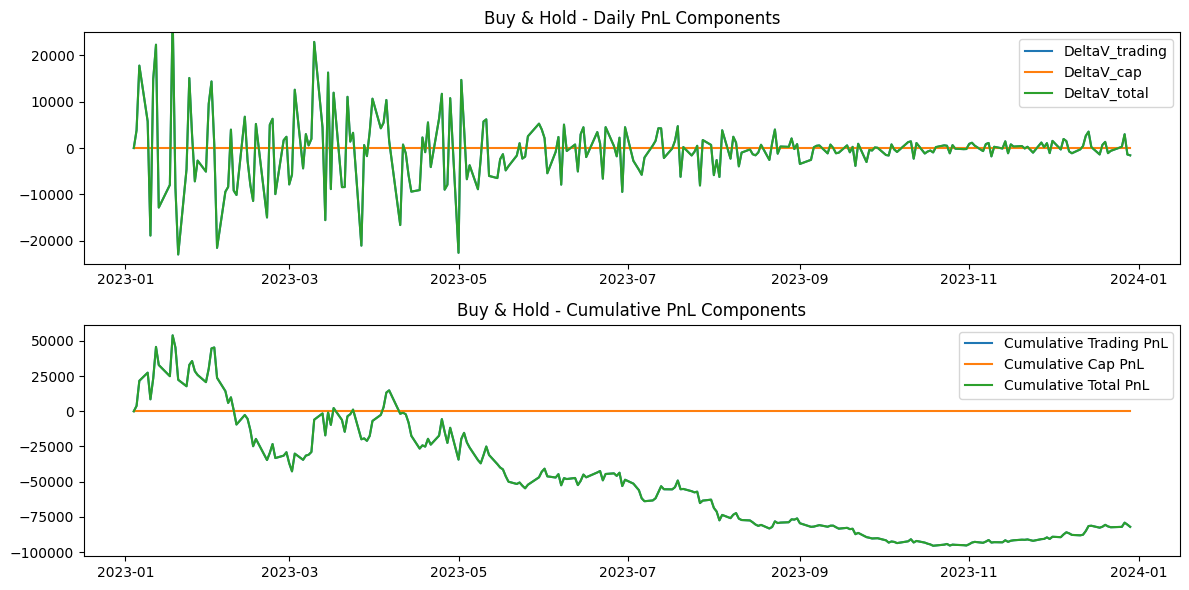

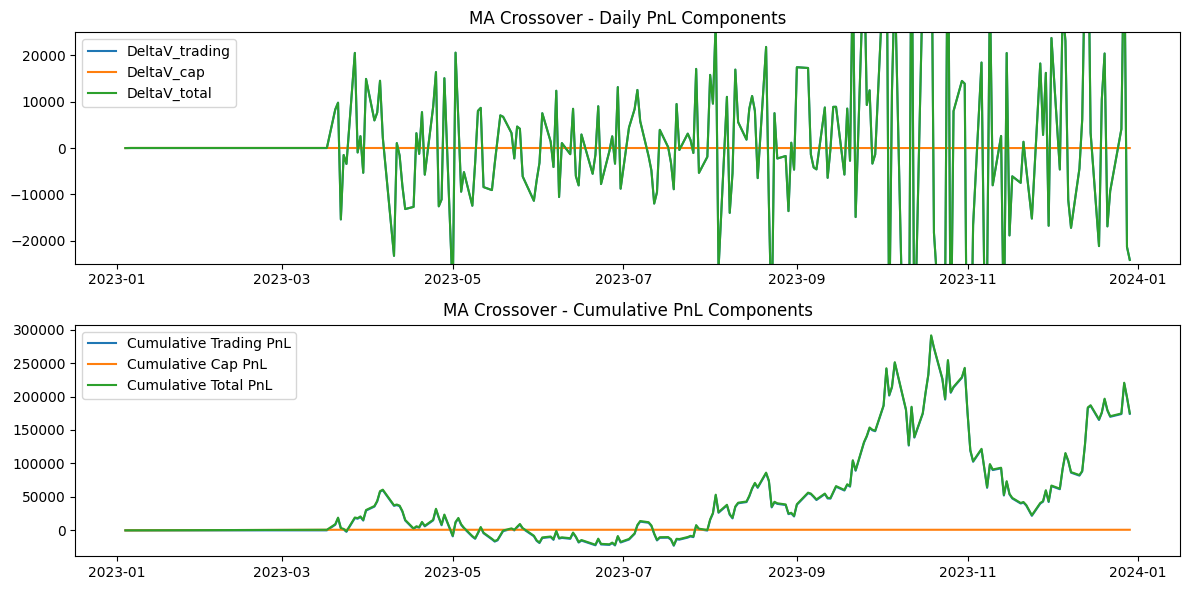

In [17]:
def plot_pnl_components(results, strategy_name):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2,1,1)
    plt.plot(results.index, results["DeltaV_trading"], label="DeltaV_trading")
    plt.plot(results.index, results["DeltaV_cap"], label="DeltaV_cap")
    plt.plot(results.index, results["DeltaV_total"], label="DeltaV_total")
    plt.ylim(-25000, 25000)
    plt.legend()
    plt.title(f"{strategy_name} - Daily PnL Components")
    
    plt.subplot(2,1,2)
    plt.plot(results.index, results["DeltaV_trading"].cumsum(), label="Cumulative Trading PnL")
    plt.plot(results.index, results["DeltaV_cap"].cumsum(), label="Cumulative Cap PnL")
    plt.plot(results.index, results["DeltaV_total"].cumsum(), label="Cumulative Total PnL")
    plt.legend()
    plt.title(f"{strategy_name} - Cumulative PnL Components")
    plt.tight_layout()
    plt.show()

plot_pnl_components(results_bh, "Buy & Hold")
plot_pnl_components(results_ma, "MA Crossover")

# Part 3: Performance Indicator
## 1. Computing Daily Returns

In [18]:
def compute_daily_return(results_df):
    """
    Given the DataFrame from run_leveraged_strategy(), 
    compute r_t = DeltaV_total[t] / V_total[t-1].
    We use shift(1) for V_total to avoid dividing by zero on t=0.
    """
    daily_ret = results_df["DeltaV_total"] / results_df["V_total"].shift(1)
    # Fill the first NaN (from t=0) with 0 or another convention
    daily_ret = daily_ret.fillna(0)
    return daily_ret


## 2. Define Shape Ratio

In [22]:
def annualized_sharpe_ratio(daily_ret, daily_rf, freq=252):
    excess_ret = daily_ret - daily_rf
    mean_ret = excess_ret.mean()
    std_ret = excess_ret.std()
    if std_ret == 0:
        return np.nan
    return (mean_ret / std_ret) * np.sqrt(freq)

## 3. Define Calmar Ratio

In [23]:
def calmar_ratio(equity_curve, freq=252):
    """
    Calmar Ratio = Annualized Return / Maximum Drawdown
    
    equity_curve: typically results_df["V_total"] (the account value over time)
    freq: number of trading days per year
    """
    # 1) Annualized Return
    final_val = equity_curve.iloc[-1]
    init_val = equity_curve.iloc[0]
    total_days = len(equity_curve)
    if total_days < 2 or init_val <= 0:
        return np.nan
    
    annual_return = (final_val / init_val)**(freq / total_days) - 1
    
    # 2) Maximum Drawdown
    running_max = equity_curve.cummax()
    drawdown = (equity_curve - running_max) / running_max  # negative values
    max_drawdown = drawdown.min()  # e.g. -0.25 means a 25% drawdown
    
    if max_drawdown == 0:
        return np.nan
    
    return annual_return / abs(max_drawdown)

## 4. Present the result in table

In [25]:
# 4. Compute Metrics
bh_daily_ret = compute_daily_return(results_bh)
ma_daily_ret = compute_daily_return(results_ma)

bh_daily_ret = bh_daily_ret.reindex(data.index, method='ffill')
ma_daily_ret = ma_daily_ret.reindex(data.index, method='ffill')
daily_rf = data['Daily_EFFR']

bh_sharpe = annualized_sharpe_ratio(bh_daily_ret, daily_rf)
ma_sharpe = annualized_sharpe_ratio(ma_daily_ret, daily_rf)

bh_calmar = calmar_ratio(results_bh["V_total"])
ma_calmar = calmar_ratio(results_ma["V_total"])

# 5. Present Results in Table
performance_table = pd.DataFrame({
    "Strategy": ["Buy & Hold", "MA Crossover"],
    "Sharpe Ratio": [bh_sharpe, ma_sharpe],
    "Calmar Ratio": [bh_calmar, ma_calmar]
})

print(performance_table)

       Strategy  Sharpe Ratio  Calmar Ratio
0    Buy & Hold     -0.226868     -0.850427
1  MA Crossover      1.391962      2.615341
